CÀI ĐẶT THƯ VIỆN

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.datasets import load_files
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score,make_scorer

%matplotlib inline

A. TRÍCH XUẤT VECTO ĐẶC TRƯNG VÀ MÃ HOÁ DANH MỤC

In [2]:
train_data = pd.read_csv("./traindatanorm.csv")
print("Raw data shape: ", train_data.shape)
test_data = pd.read_csv("./testdatanorm.csv")
print("Raw data shape: ", test_data.shape)

Raw data shape:  (7809, 5)
Raw data shape:  (1959, 5)


1. Gộp các biến phụ thuộc thành 1 cột 

In [3]:
train_data['combined_features'] = train_data['Course_Title']+ ' ' + train_data['Description']+ ' ' + train_data['Course_Content']+ train_data['Lecturers_name']
test_data['combined_features'] = test_data['Course_Title']+ ' ' + test_data['Description']+ ' ' + test_data['Course_Content']+ test_data['Lecturers_name']

# Kiểm tra dữ liệu đã được kết hợp
print(train_data['combined_features'].head())
print(test_data['combined_features'].head())

0    complet javascript 2024 zero expert modern jav...
1    javascript weird part advanc javascript everyo...
2    javascript basic beginn javascript master fund...
3    modern javascript begin 2.0 2024 36 hour maste...
4    javascript beginn practic exercis javascript b...
Name: combined_features, dtype: object
0    full javascript es6 tutori includ es7 react de...
1    javascript web advanc web javascript javascrip...
2    javascript beginn javascript scratch javascrip...
3    javascript beginn javascript onlin supercharg ...
4    css javascript certif beginn add dynam client ...
Name: combined_features, dtype: object


2. Biểu đồ Số lượng khoá học cho từng Danh mục(loại khoá học)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10624\1959430250.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Main_Category', data=train_data, palette='pastel')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10624\1959430250.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


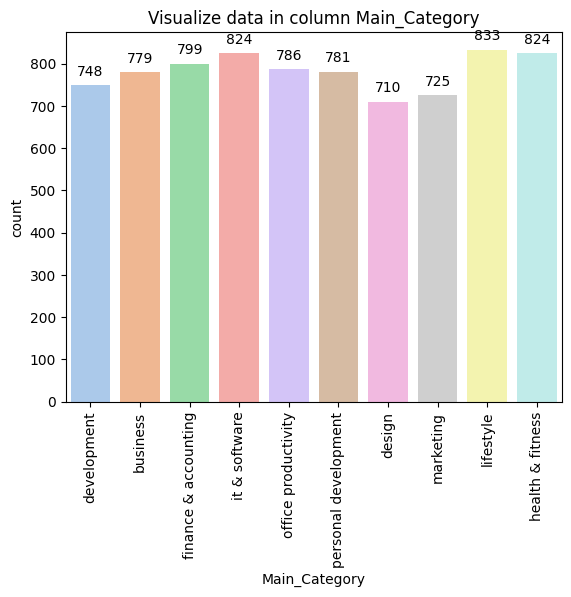

Tổng số khoá học: 7809


In [4]:
ax = sns.countplot(x='Main_Category', data=train_data, palette='pastel')
plt.title('Visualize data in column Main_Category')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.show()
total_courses = len(train_data)  # hoặc data.shape[0]
print("Tổng số khoá học:", total_courses)

2. Chia dữ liệu thành tập train và test

In [4]:

# Chia dữ liệu thành tập train và tập test
X_train, X_val, y_train, y_val = train_test_split(train_data['combined_features'],
                                                     train_data['Main_Category'], 
                                                     test_size=0.2, 
                                                     random_state=42)

                                                     
X_test = test_data['combined_features']
y_test = test_data['Main_Category']

print(f"Test set size: {len(X_test)} samples")
print(f"Train set size: {len(X_train)} samples")
print(f"Val set size: {len(X_val)} samples")

Test set size: 1959 samples
Train set size: 6247 samples
Val set size: 1562 samples


3. Mã hoá danh mục

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_n = encoder.fit_transform(y_train)
y_val_n = encoder.fit_transform(y_val)
y_test_n = encoder.fit_transform(y_test)
taget_name = encoder.classes_

In [8]:
print(taget_name)

['business' 'design' 'development' 'finance & accounting'
 'health & fitness' 'it & software' 'lifestyle' 'marketing'
 'office productivity' 'personal development']


4. Trích xuất vecto đặc trưng TF-IDF 

In [6]:
tfidf_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_val_tfidf = tfidf_vect.transform(X_val)
X_test_tfidf = tfidf_vect.transform(X_test)

In [7]:
print("Vector hoá tập Train TF-IDF ",X_train_tfidf.data)
print("Kích thước vector ",X_train_tfidf.shape)
print("Vector hoá tập Test TF-IDF ",X_val_tfidf.data)
print("Kích thước vector ",X_val_tfidf.shape)

print("Vector hoá tập Test TF-IDF ",X_test_tfidf.data)
print("Kích thước vector ",X_test_tfidf.shape)


Vector hoá tập Train TF-IDF  [0.20490082 0.14828353 0.10218578 ... 0.16872524 0.10675982 0.21467164]
Kích thước vector  (6247, 17595)
Vector hoá tập Test TF-IDF  [0.38407209 0.09202011 0.19359701 ... 0.13918965 0.14387461 0.11387706]
Kích thước vector  (1562, 17595)
Vector hoá tập Test TF-IDF  [0.10313493 0.05425599 0.14933461 ... 0.14788171 0.16833792 0.13737379]
Kích thước vector  (1959, 17595)


5. Giảm chiều dữ liệu SVD

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5400, random_state=42)
svd.fit(X_train_tfidf)

X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_val_tfidf_svd = svd.transform(X_val_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)


In [12]:

print("Vector hoá tập Train SVD TF-IDF ",X_train_tfidf_svd.data)
print("Kích thước vector ",X_train_tfidf_svd.shape)
print("Vector hoá tập Val SVD TF-IDF ",X_val_tfidf_svd.data)
print("Kích thước vector ",X_val_tfidf_svd.shape)

print("Vector hoá tập Test SVD TF-IDF ",X_test_tfidf_svd.data)
print("Kích thước vector ",X_test_tfidf_svd.shape)

Vector hoá tập Train SVD TF-IDF  <memory at 0x0000022FD4275FF0>
Kích thước vector  (6247, 5400)
Vector hoá tập Val SVD TF-IDF  <memory at 0x0000022FD4275FF0>
Kích thước vector  (1562, 5400)
Vector hoá tập Test SVD TF-IDF  <memory at 0x0000022FD4275FF0>
Kích thước vector  (1959, 5400)


B. HIỆU CHỈNH

1. Lựa chọn tham số tối ưu

In [13]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train_tfidf, y_train_n, cv=10, n_jobs=-1, 
                                                  train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

a. Đánh giá dựa trên kernal

100%|██████████| 4/4 [04:06<00:00, 61.58s/it]


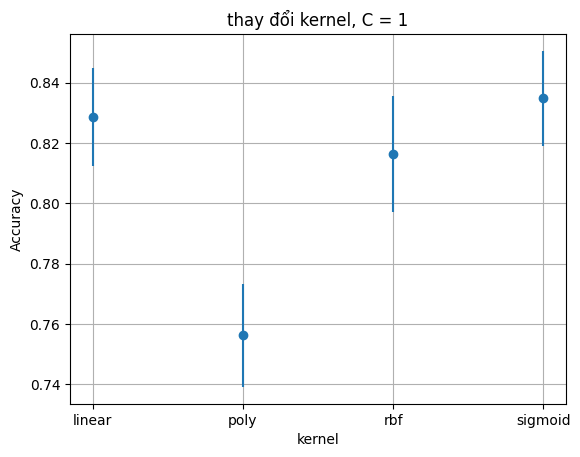

In [14]:
from tqdm import tqdm

title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)
plot(title, xlabel, X, Y, error)
plt.show()


b. Đánh giá dựa trên C

100%|██████████| 5/5 [04:09<00:00, 49.99s/it]


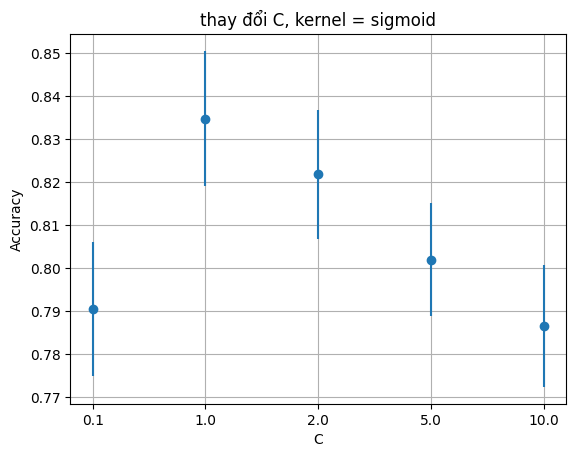

In [15]:
title = "thay đổi C, kernel = sigmoid"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    text_clf = svm.SVC(kernel='sigmoid', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()


2. Hiệu chỉnh: Lấy kernal = sigmoid , C = 1.0

In [9]:
svc_model_after = SVC(kernel='sigmoid', C=1.0, random_state=42)
svc_model_after.fit(X_train_tfidf_svd, y_train_n)

SVC(kernel='sigmoid', random_state=42)

3. Kết quả sau khi hiệu chỉnh

3.1 Trên tập train:

In [10]:
# Đánh giá mô hình trên tập huấn luyện
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
train_predictions = svc_model_after.predict(X_train_tfidf_svd)
print("Accuracy on training set:", accuracy_score(y_train_n, train_predictions))
print("Classification report on training set:\n", classification_report(y_train_n, train_predictions, target_names=taget_name))


Accuracy on training set: 0.9013926684808709
Classification report on training set:
                       precision    recall  f1-score   support

            business       0.73      0.81      0.77       611
              design       0.88      0.86      0.87       571
         development       0.86      0.89      0.87       587
finance & accounting       0.94      0.91      0.92       648
    health & fitness       0.99      0.98      0.98       666
       it & software       0.96      0.90      0.93       668
           lifestyle       0.94      0.98      0.96       649
           marketing       0.90      0.85      0.87       575
 office productivity       0.90      0.95      0.92       647
personal development       0.92      0.87      0.90       625

            accuracy                           0.90      6247
           macro avg       0.90      0.90      0.90      6247
        weighted avg       0.90      0.90      0.90      6247



In [12]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix SVM')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

3.2 Trên tập validation:

Accuracy on test set: 0.822663252240717
Classification report on test set:
                       precision    recall  f1-score   support

            business       0.60      0.70      0.65       168
              design       0.77      0.80      0.78       139
         development       0.77      0.76      0.76       161
finance & accounting       0.90      0.86      0.88       151
    health & fitness       0.92      0.89      0.91       158
       it & software       0.88      0.86      0.87       156
           lifestyle       0.92      0.90      0.91       184
           marketing       0.85      0.77      0.81       150
 office productivity       0.90      0.92      0.91       139
personal development       0.79      0.76      0.78       156

            accuracy                           0.82      1562
           macro avg       0.83      0.82      0.82      1562
        weighted avg       0.83      0.82      0.82      1562



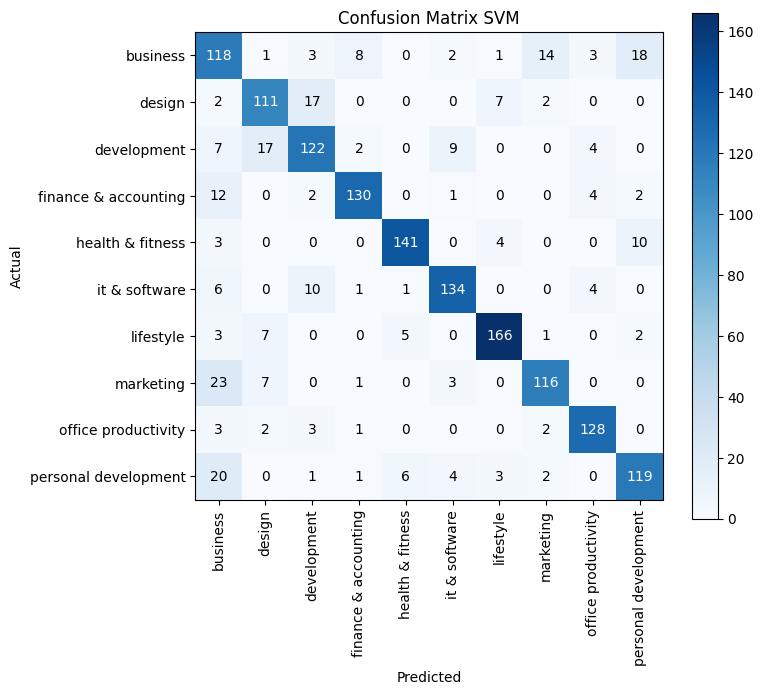

In [13]:
# Đánh giá mô hình trên tập kiểm tra
val_predictions_after = svc_model_after.predict(X_val_tfidf_svd)
print("Accuracy on test set:", accuracy_score(y_val_n, val_predictions_after))
print("Classification report on test set:\n", classification_report(y_val_n, val_predictions_after ,target_names=taget_name))
plot_confusion_matrix(y_val_n, val_predictions_after, taget_name)

3.3 Trên tập test:

Accuracy on test set: 0.8111281265952016
Classification report on test set:
                       precision    recall  f1-score   support

            business       0.63      0.70      0.66       214
              design       0.82      0.80      0.81       191
         development       0.80      0.85      0.82       210
finance & accounting       0.81      0.82      0.82       176
    health & fitness       0.88      0.90      0.89       186
       it & software       0.91      0.82      0.86       224
           lifestyle       0.86      0.89      0.87       192
           marketing       0.85      0.77      0.81       185
 office productivity       0.86      0.89      0.88       169
personal development       0.73      0.71      0.72       212

            accuracy                           0.81      1959
           macro avg       0.82      0.81      0.81      1959
        weighted avg       0.81      0.81      0.81      1959



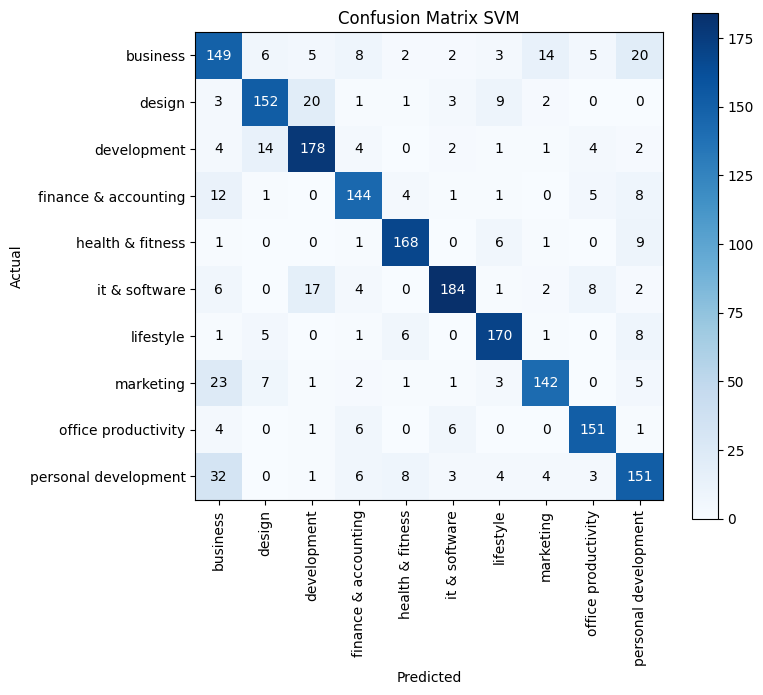

In [14]:
# Đánh giá mô hình trên tập kiểm tra
test_predictions_after = svc_model_after.predict(X_test_tfidf_svd)
print("Accuracy on test set:", accuracy_score(y_test_n, test_predictions_after))
print("Classification report on test set:\n", classification_report(y_test_n, test_predictions_after ,target_names=taget_name))
plot_confusion_matrix(y_test_n, test_predictions_after, taget_name)

3.4 Chỉ số Accuracy, Precision, Recall, F1-Score trên tập train, test, validation

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Huấn luyện
train_predictions = svc_model_after.predict(X_train_tfidf_svd)
# Xác thực
val_predictions_after = svc_model_after.predict(X_val_tfidf_svd)
# Kiểm tra
test_predictions_after = svc_model_after.predict(X_test_tfidf_svd)

# Tính các độ đo
metrics = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Accuracy': [
        accuracy_score(y_train_n, train_predictions),
        accuracy_score(y_val_n, val_predictions_after),
        accuracy_score(y_test_n, test_predictions_after)
    ],
    'Precision': [
        precision_score(y_train_n, train_predictions, average='macro'),
        precision_score(y_val_n, val_predictions_after, average='macro'),
        precision_score(y_test_n, test_predictions_after, average='macro')
    ],
    'Recall': [
        recall_score(y_train_n, train_predictions, average='macro'),
        recall_score(y_val_n, val_predictions_after, average='macro'),
        recall_score(y_test_n, test_predictions_after, average='macro')
    ],
    'F1 Score': [
        f1_score(y_train_n, train_predictions, average='macro'),
        f1_score(y_val_n, val_predictions_after, average='macro'),
        f1_score(y_test_n, test_predictions_after, average='macro')
    ]
}

import pandas as pd

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


      Dataset  Accuracy  Precision    Recall  F1 Score
0       Train  0.901393   0.901830  0.899348  0.899959
1  Validation  0.822663   0.828384  0.823020  0.824958
2        Test  0.811128   0.816238  0.814127  0.814417
